In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


# Analysis of differential expression results

In [2]:
gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

In [3]:
diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)


ERROR: Error in fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", : File 'pipeline/4.1.differential_expression/diffexp_cell.txt' does not exist or is non-readable. getwd()=='/frazer01/projects/CARDIPS/analysis/cardiac_eqtls'


In [ ]:
testtiss = fread(paste("pipeline/4.1.differential_expression", "functional_enrichment.tissue.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
testcell = fread(paste("pipeline/4.1.differential_expression", "functional_enrichment.cell.txt"  , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
testtiss$ttest_delta =      testtiss$ttest_estimate_in - testtiss$ttest_estimate_out
testcell$ttest_delta =      testcell$ttest_estimate_in - testcell$ttest_estimate_out


In [ ]:
msigdb               = c("c2.cp.biocarta", "c2.cp.kegg", "c2.cp.reactome", "c5.bp", "c5.cc", "c5.mf", "h.all")


In [ ]:
type = "gene_tpm"

tests_tiss_top = as.data.frame(rbindlist(lapply(sort(unique(testtiss$tissue1)), function(tissue1)
{
    this_test = testtiss[testtiss$type == type & testtiss$tissue1 == tissue1,]
    as.data.frame(rbindlist(lapply(sort(unique(this_test$tissue2)), function(tissue2)
    {
        this = this_test[this_test$tissue2 == tissue2 & this_test$ttest_estimate_in > this_test$ttest_estimate_out,]
        this = this[order(this$ttest_pval),]
        return(this[1:5,])
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

tests_tiss_bottom = as.data.frame(rbindlist(lapply(sort(unique(testtiss$tissue1)), function(tissue1)
{
    this_test = testtiss[testtiss$type == type & testtiss$tissue1 == tissue1,]
    as.data.frame(rbindlist(lapply(sort(unique(this_test$tissue2)), function(tissue2)
    {
        this = this_test[this_test$tissue2 == tissue2 & this_test$ttest_estimate_in < this_test$ttest_estimate_out,]
        this = this[order(this$ttest_pval),]
        return(this[1:5,])
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)



In [ ]:
tests_tiss_top   [, c("tissue1", "tissue2", "gs_source", "gene_set", 'ngenes', 'ttest_estimate_in', 'ttest_estimate_out', 'ttest_pval', "ttest_fdr")]
tests_tiss_bottom[, c("tissue1", "tissue2", "gs_source", "gene_set", 'ngenes', 'ttest_estimate_in', 'ttest_estimate_out', 'ttest_pval', "ttest_fdr")]


In [ ]:
tests_cell_top = as.data.frame(rbindlist(lapply(sort(unique(testcell$cell_type)), function(cell_type)
{
    this = testcell[testcell$cell_type == cell_type & testcell$ttest_estimate_in > testcell$ttest_estimate_out,]
    this = this[order(this$ttest_pval),]
    return(this[1:5,])
})), stringsAsFactors = FALSE)

tests_cell_top[, c("cell_type", "gs_source", "gene_set", 'ngenes', 'ttest_estimate_in', 'ttest_estimate_out', 'ttest_pval', "ttest_fdr")]


# heatmap?

In [42]:
library(pheatmap)

## Tissue

In [62]:
genesets2plot = c("HALLMARK_G2M_CHECKPOINT", "GO_RNA_PROCESSING", "GO_CELL_CYCLE",
                  "GO_DEFENSE_RESPONSE", "GO_ADAPTIVE_IMMUNE_RESPONSE", "GO_INFLAMMATORY_RESPONSE",
                  "GO_MITOCHONDRION", "HALLMARK_OXIDATIVE_PHOSPHORYLATION", "GO_CELLULAR_RESPIRATION"
                 )

testtiss$tissue  = paste(testtiss$tissue1, testtiss$tissue2, sep = " vs. ")
toplot           = matrix(0, nrow = length(genesets2plot), ncol = length(unique(testtiss$tissue)))
rownames(toplot) = genesets2plot
colnames(toplot) = sort(unique(testtiss$tissue))
toplot           = as.data.frame(toplot)


for(tissue in colnames(toplot))
{
    this            = testtiss[testtiss$tissue == tissue & testtiss$type == "gene_tpm",]
    rownames(this)  = this$gene_set
    toplot[,tissue] = this[rownames(toplot), "ttest_delta"]
    
}

toplot = as.matrix(toplot)
toplot[toplot >  0.8] =  0.8
toplot[toplot < -0.8] = -0.8

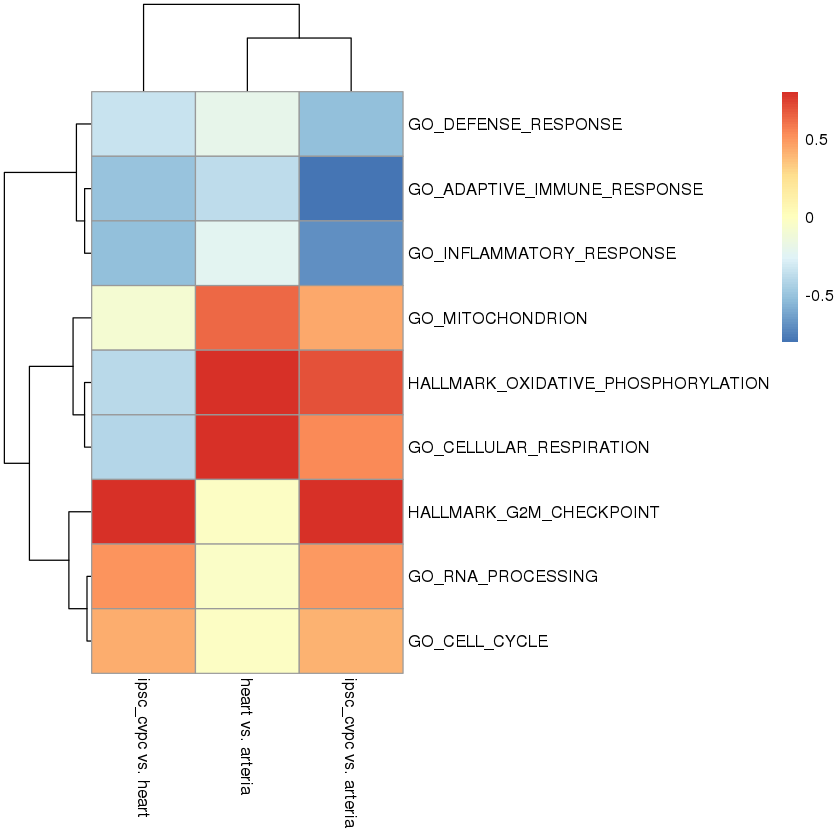

In [64]:
pheatmap(as.matrix(toplot))

## Cell type

In [46]:
genesets2plot = c("GO_MITOCHONDRION", "GO_CONTRACTILE_FIBER", "GO_CARDIAC_MUSCLE_CELL_CONTRACTION", 
                  "GO_NEURON_DIFFERENTIATION", "GO_REGULATION_OF_NERVOUS_SYSTEM_DEVELOPMENT",
                  "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION", "REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION",
                  "GO_ENDOTHELIAL_CELL_MIGRATION", "GO_ENDOTHELIUM_DEVELOPMENT",
                  "GO_EXTRACELLULAR_MATRIX", "GO_POSITIVE_REGULATION_OF_FIBROBLAST_PROLIFERATION",
                  "GO_REGULATION_OF_IMMUNE_SYSTEM_PROCESS", "GO_INNATE_IMMUNE_RESPONSE",
                  "REACTOME_SMOOTH_MUSCLE_CONTRACTION"
                 )

toplot           = matrix(0, nrow = length(genesets2plot), ncol = length(unique(testcell$cell_type)))
rownames(toplot) = genesets2plot
colnames(toplot) = sort(unique(testcell$cell_type))
toplot           = as.data.frame(toplot)

for(cell in colnames(toplot))
{
    this = testcell[testcell$cell_type == cell,]
    rownames(this) = this$gene_set
    toplot[,cell]  = this[rownames(toplot), "ttest_delta"]
    
}

toplot = as.matrix(toplot)
toplot[toplot >  2] =  2
toplot[toplot < -2] = -2

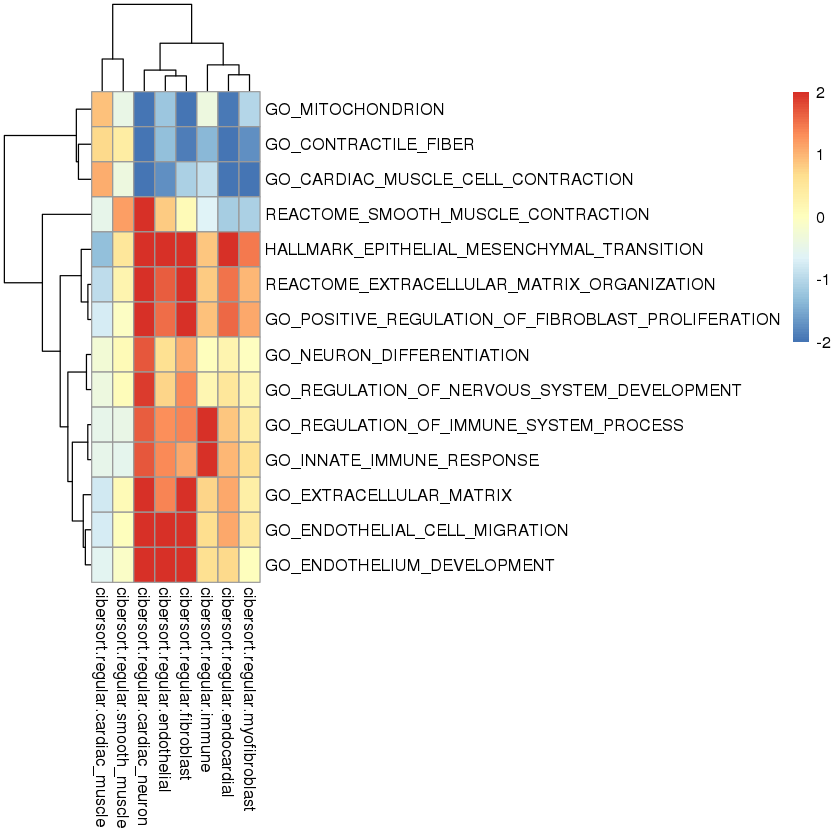

In [47]:
pheatmap(as.matrix(toplot))